In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Dimensionality Reduction and Clustering Exercise

In this exercise we'll have a look at the [free energy surface of alanindipeptide](https://pubs.acs.org/doi/10.1021/acs.chemrev.5b00584). Historically, the Ramachandran Plot, the value of the $\varphi$ and $\psi$ dihedrals, has proven itself as meaningful method to predict the structure of peptides. In vacuum we will find different energy minimum structures at different dihedral combinations. We'll refer to them as $C_5^{ext}$, $C_7^{eq}$, $\alpha '$ and $C_7^{ax}$, as it has been reported in the literature and can be seen in the left picture.

We'll provide you with the structure of a biased molecular dynamics simulation, which will find minimum strucutures as well as non-minimum structures. You'll see the respective free energy surface in the center. On the right you see a scatter plot of all the structures we'll provide you with. The areas, which have been assigned to the respecitve minima are marked. We'll also provide you with these labels.

An unbiased simulation would be more realistic for this exercise, but we only had this data at hand :D

MDAnalysis is probably not in your environment yet, you can get it via `conda install -c conda-forge mdanalysis`.

<img src="https://www.researchgate.net/publication/368261458/figure/fig2/AS:11431281192133045@1695730170659/Structure-of-alanine-dipeptide.tif" alt="drawing" width="300"/>

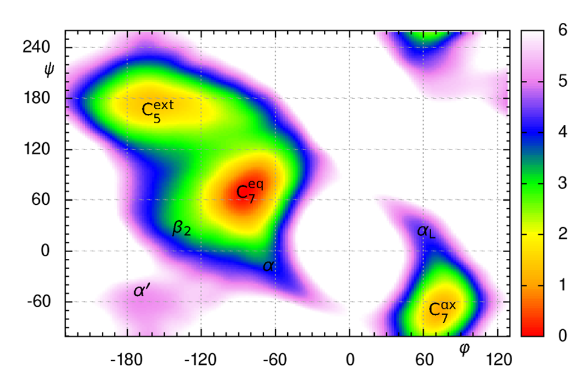
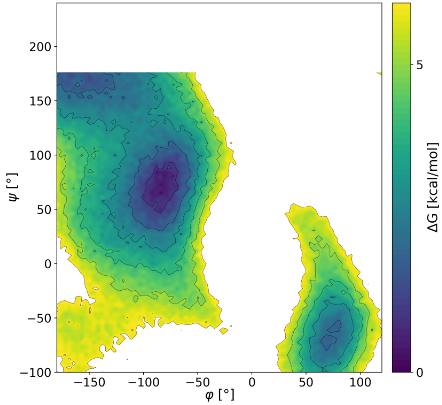
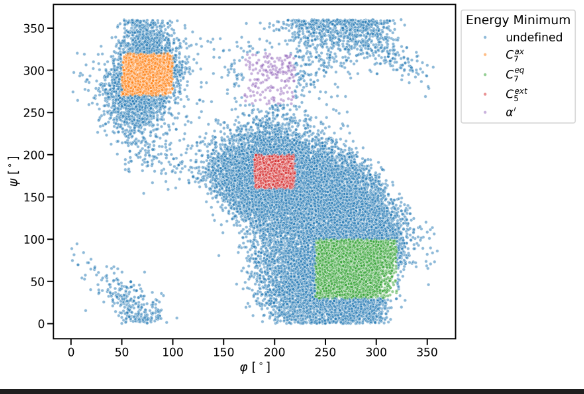

We'll use a new library to deal with the coordinates of the molecular dynamics simulation: MDAnalysis. This library can read trajectory data, manipulate and analyze it. Here's how it's done:

In [ ]:
file: str = "geoms.xyz"
u: mda.core.universe.Universe = mda.Universe(file)
atoms: mda.core.groups.AtomGroup = u.select_atoms('all')
n_atoms: int = len(atoms)
n_time_steps: int = len(u.trajectory)
n_distances: int = n_atoms * (n_atoms - 1) // 2 # small gaussian sum for number of distances

all_self_distances: np.ndarray = np.zeros((n_time_steps, n_distances)) # placeholder with shape (n_time_steps, n_distances)
for time_step in u.trajectory:
    self_distances: np.ndarray = distances.self_distance_array(atoms.positions) # shape (n_distances)
    all_self_distances[time_step.frame] = self_distances # store the distances for this time step in the placeholder

print(f"all_self_distances.shape: {all_self_distances.shape}")

`all_self_distances` is the data that we'll use for our dimension reduction. It's a flattened distance matrix for all `self_distances` of every structure. The entries on the diagonal of the distance matrix are zero and the lower and the upper triangular matrix contain the same information, so only one of them is kept.

\begin{equation*}
  \textrm{distance matrix} =
\begin{pmatrix}
  0   & r_{1,2}  & \cdots  & r_{1,n}  \\
  r_{1,2}   & 0  & \cdots  & r_{2,n}  \\
  \vdots  & \vdots & \ddots  & \vdots \\
  r_{1,n}  & r_{2,n}  & \cdots  & 0  \\
\end{pmatrix}
\end{equation*}

\begin{equation*}
\textrm{self distances} = 
\begin{pmatrix}
r_{1,2} \\
r_{1,3} \\
r_{1,4} \\
\vdots \\
r_{n-1,n}
\end{pmatrix}
\end{equation*}

Having the data as pd.DataFrame is also handy. I'll prepare a DataFrame with the minimum labels for you and you'll fill it along the exercise

In [ ]:
label_file_name: str = "dihedral_labels.dat"
df = pd.read_csv(label_file_name, header=None, names=["Minimum"])

The biased simulation introduces a lot of intermediate structures, which can't be assigned to one miniumum. This noise will make clustering difficult. Let's focus on the minimum structures to observe proper clustering by filtering out the `undefined` strucutres.

Create a variable called `boolean_mask`. This should contain boolean values, whether the `df["Minimum"]` is neither `"undefined"` nor `"$\alpha'$"`(because this tiny cluster messes up the clustering). Then filter the `df` and the `all_self_distances` to only keep the minimum structures. Overwrite the current variables using boolean indexing.

In [ ]:
boolean_mask: pd.Series = None # Your code here
df: pd.DataFrame = None # Your code here
all_self_distances: None # Your code here

In [ ]:
# Test cell

assert boolean_mask is not None, "The boolean_mask is not defined"
assert boolean_mask.shape == (24000,), f"The boolean mask has the wrong shape, expected (7576,), got {boolean_mask.shape}"
assert len(df) == 7576, f"The dataframe has the wrong length, expected 7576, got {len(df)}"
assert all_self_distances.shape == (7576, 231), f"The all_self_distances array has the wrong shape, expected (7576, 231), got {all_self_distances.shape}"

You now have access to the input we'd like to use for the dimensionality reduction. Start with the PCA and transform the 231 dimensional distances into a 10 dimensional object. Call the PCA variable `pca` and the resulting array `pca_result`. Create a variable called `explained_variance` and `explained_variance_2_pcs`, which contain the percentage of explained variance by the first 10 and only the first 2 PCs. 

In [ ]:
pca: PCA = None # Your code here
pca_result: np.ndarray = None # Your code here

explained_variance: float = None # Your code here
explained_variance_2_pcs: float = None # Your code here

print(f"Explained variance of PCA with 10 components: {explained_variance}")
print(f"Explained variance of PCA with 2 components: {explained_variance_2_pcs}")

In [ ]:
# Test cell

assert pca is not None, "The PCA object is not defined"
assert pca_result is not None, "The PCA result is not defined"
assert explained_variance is not None, "The explained variance is not defined"
assert explained_variance_2_pcs is not None, "The explained variance with 2 components is not defined"

assert pca.n_components_ == 10, f"The number of components is wrong, expected 10, got {pca.n_components_}"
assert hasattr(pca, "explained_variance_ratio_"), "The PCA object hasn't been fitted"

assert explained_variance > 0.7, f"The explained variance is too low, expected > 0.7, got {explained_variance}"
assert explained_variance_2_pcs > 0.4, f"The explained variance with 2 components is too low, expected > 0.4, got {explained_variance_2_pcs}"

Now add the first and the second PC to the DataFrame `df` with the column names `"PC 1"` and `"PC 2"` and call the plotting function `plot_pca` to see the result.

In [ ]:
def plot_generic(df: pd.DataFrame, x: str, y: str, hue="Minimum", style: str = None, centroids=None) -> None:
    FONTSIZE = 20
    LABELSIZE = 15
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    sns.scatterplot(
    x=x, y=y, style=style,
    hue=hue,
    palette=sns.color_palette("hls"),
    data=df,
    legend="full",
    alpha=0.3)

    if centroids is not None:
        sns.scatterplot(x=centroids[:,0], y=centroids[:,1], color='red', s=100, label='Centroids', ax=ax)

    ax.set_xlabel('PC 1', fontsize=FONTSIZE)
    ax.set_ylabel('PC 2', fontsize=FONTSIZE)
    plt.tick_params(axis='both', which="major", labelsize=LABELSIZE)
    legend = plt.legend(title='Minimum', fontsize=FONTSIZE, title_fontsize=FONTSIZE, loc='upper left', bbox_to_anchor=(1.05, 1))
    for legend_handle in legend.legendHandles: 
        legend_handle.set_alpha(1)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_pca(df: pd.DataFrame) -> None:
    plot_generic(df, "PC 1", "PC 2")

df["PC 1"] = None # Your code here
df["PC 2"] = None # Your code here
# Your code here

Repeat the same procdeure for t-SNE.

Create a variable called `tsne` for the t-SNE object with n_components=2 and perplexity=40. Fit the t-SNE object to `all_self_distances` and store the result in `tsne_result`. Add the components to the DataFrame with the column names `"tSNE 1"` and `"tSNE 2"`. Call the plotting_function `plot_tsne`.

In [ ]:
def plot_tsne(df: pd.DataFrame) -> None:
    plot_generic(df, "tSNE 1", "tSNE 2")

tsne: TSNE = None # Your code here
tsne_result: np.ndarray = None # Your code here

df['tSNE 1'] = None # Your code here
df['tSNE 2'] = None # Your code here

# Your code here

In [ ]:
# Test cell

assert tsne is not None, "The t-SNE object is not defined"
assert tsne_result is not None, "The t-SNE result is not defined"
assert tsne.perplexity == 40, f"The perplexity is wrong, expected 30, got {tsne.perplexity}"

t-SNE managed to preserve a 3 Cluster symmetry from the data. Let's see what happens, when we remove hydrogen from the distance matrix:

Take `all_heavy_atoms_self_distances` and use it to fir another t-SNE object called `heavy_tsne`. Overwrite the current tsne column in the `df` and plot the result again.

In [ ]:
heavy_atoms: mda.core.groups.AtomGroup = u.select_atoms('not type H')
n_heavy_atoms: int = len(heavy_atoms)
n_heavy_atom_distances: int = n_heavy_atoms * (n_heavy_atoms - 1) // 2 # small gaussian sum for number of distances

all_heavy_atoms_self_distances: np.ndarray = np.zeros((n_time_steps, n_heavy_atom_distances)) # placeholder with shape (n_time_steps, n_distances)
for time_step in u.trajectory:
    heavy_atoms_self_distances: np.ndarray = distances.self_distance_array(heavy_atoms.positions) # shape (n_distances)
    all_heavy_atoms_self_distances[time_step.frame] = heavy_atoms_self_distances # store the distances for this time step in the placeholder

all_heavy_atoms_self_distances: np.ndarray = all_heavy_atoms_self_distances[boolean_mask]

In [ ]:
heavy_tsne: TSNE = None # Your code here
heavy_tsne_result: np.ndarray = None # Your code here

df['tSNE 1'] = None # Your code here
df['tSNE 2'] = None # Your code here

plot_tsne(df)

Now we can use the reduced dimension for clustering.

Create a KMeans object called `kmeans`, fit it to the `pca_result` and save the prediction of the fit to a variable called `kmeans_result`. Then access the position of the centroids using `kmeans.cluster_centers_` and save it to a variable called `centroids`.

Call `plot_generic` with `(df, "PC 1", "PC 2", hue=kmeans_result, centroids=centroids)`

Repeat the same process with `heavy_tsne_result`.


In [ ]:
kmeans: KMeans = None # Your code here
kmeans_result: np.ndarray = None # Your code here
centroids: np.ndarray = None # Your code here

# Your code here

kmeans: KMeans = None # Your code here
kmeans_result: np.ndarray = None # Your code here
centroids = None # Your code here

# Your code here